# Pickles analysis result

this notebook has been created by Emmanouil to analize the difference between his optimized model and the original one applied in the different people available.

In [3]:
# ======================================================
# PRINT RAW PICKLE STRUCTURE (RECURSIVE, SAFE)
# ======================================================

import os
import pickle
import numpy as np

ROOT_PATH = (
    "/run/user/1037/gvfs/smb-share:server=ait-pdfs.win.dtu.dk,share=department/Man/"
    "Public/4233-81647-eMOTIONAL-Cities/5 Data/ECDTU/E4/completed"
)

SUBJ = "162"          # άλλαξε αν θέλεις
PKL_NAME = None       # None → παίρνει το πρώτο test_results_thr*.pkl


# ------------------------------------------------------
# Load pickle
# ------------------------------------------------------
data_path = os.path.join(ROOT_PATH, SUBJ, "Data")

pkl_files = sorted([
    f for f in os.listdir(data_path)
    if f.startswith("test_results_thr") and f.endswith(".pkl")
])

assert len(pkl_files) > 0, "Δεν βρέθηκε test_results pickle"

if PKL_NAME is None:
    PKL_NAME = pkl_files[0]

pkl_path = os.path.join(data_path, PKL_NAME)
print("Loading pickle:", pkl_path)

with open(pkl_path, "rb") as f:
    data = pickle.load(f)


# ------------------------------------------------------
# Recursive pretty printer
# ------------------------------------------------------
def print_structure(obj, indent=0, max_list_preview=3):
    pad = "  " * indent
    t = type(obj)

    # ---- dict ----
    if isinstance(obj, dict):
        print(f"{pad}dict (keys={len(obj)})")
        for k, v in obj.items():
            print(f"{pad}- key: {k!r}")
            print_structure(v, indent + 1)

    # ---- list / tuple ----
    elif isinstance(obj, (list, tuple)):
        print(f"{pad}{t.__name__} (len={len(obj)})")
        for i, v in enumerate(obj[:max_list_preview]):
            print(f"{pad}  [{i}]")
            print_structure(v, indent + 2)
        if len(obj) > max_list_preview:
            print(f"{pad}  ... ({len(obj) - max_list_preview} more elements)")

    # ---- numpy array ----
    elif isinstance(obj, np.ndarray):
        print(f"{pad}ndarray shape={obj.shape}, dtype={obj.dtype}")

    # ---- torch tensor (optional) ----
    elif "torch" in str(type(obj)):
        try:
            print(f"{pad}torch.Tensor shape={tuple(obj.shape)}, dtype={obj.dtype}")
        except Exception:
            print(f"{pad}{t}")

    # ---- primitive ----
    else:
        # keep primitives readable
        if isinstance(obj, (int, float, str, bool, type(None))):
            print(f"{pad}{t.__name__}: {obj}")
        else:
            print(f"{pad}{t}")


# ------------------------------------------------------
# PRINT EVERYTHING
# ------------------------------------------------------
print("\n================ RAW PICKLE STRUCTURE ================\n")
print_structure(data)


Loading pickle: /run/user/1037/gvfs/smb-share:server=ait-pdfs.win.dtu.dk,share=department/Man/Public/4233-81647-eMOTIONAL-Cities/5 Data/ECDTU/E4/completed/162/Data/test_results_thr6_5.pkl

================ RAW PICKLE STRUCTURE ================

dict (keys=10)
- key: 'threshold'
  float64: 6.5
- key: 'mean_acc'
  float64: 0.28145327145140653
- key: 'mean_acc_stress'
  float64: 0.7933377484616629
- key: 'mean_sil'
  float64: 0.6856110870838166
- key: 'std_sil'
  float64: 0.02272358728997441
- key: 'fold_results'
  list (len=10)
    [0]
      dict (keys=19)
      - key: 'fold'
        int: 0
      - key: 'acc'
        float: 0.28665343587199205
      - key: 'acc_stress'
        float: 0.7678571428571429
      - key: 'sil'
        float: 0.7014078497886658
      - key: 'time_sec'
        ndarray shape=(8062,), dtype=int64
      - key: 'ema_idx'
        ndarray shape=(8062,), dtype=int64
      - key: 't0_bvp'
        float64: 1706704062.0
      - key: 't0_datetime'
        <class 'pandas._l

In [6]:
# ======================================================
# COMPARE TEST vs MARTA TEST RESULTS — MEAN-LEVEL ONLY
# ======================================================

import os
import re
import pickle
import pandas as pd

ROOT_PATH = (
    "/run/user/1037/gvfs/smb-share:server=ait-pdfs.win.dtu.dk,share=department/Man/"
    "Public/4233-81647-eMOTIONAL-Cities/5 Data/ECDTU/E4/completed"
)

# ------------------------------------------------------
# Helper: extract threshold from filename
# ------------------------------------------------------
def extract_thr(fname):
    """
    test_results_thr6_5.pkl → 6.5
    """
    m = re.search(r"thr([0-9_]+)", fname)
    if m is None:
        return None
    return float(m.group(1).replace("_", "."))


# ------------------------------------------------------
# Main containers
# ------------------------------------------------------
rows_1thr = []
rows_2thr = []
rows_3thr = []


# ------------------------------------------------------
# Iterate participants
# ------------------------------------------------------
for subj in sorted(os.listdir(ROOT_PATH)):

    subj_path = os.path.join(ROOT_PATH, subj, "Data")
    if not os.path.isdir(subj_path):
        continue

    files = os.listdir(subj_path)

    test_pkls = [f for f in files if f.startswith("test_results_thr")]
    marta_pkls = [f for f in files if "marta_test_results_thr" in f.lower()]

    if len(test_pkls) == 0 or len(marta_pkls) == 0:
        continue

    # map: threshold → pickle
    test_map = {extract_thr(f): f for f in test_pkls}
    marta_map = {extract_thr(f): f for f in marta_pkls}

    common_thrs = sorted(set(test_map) & set(marta_map))
    if len(common_thrs) == 0:
        continue

    # --------------------------------------------------
    # HARD EXCLUDE participant if ANY silhouette is NaN
    # --------------------------------------------------
    exclude_participant = False

    for thr in common_thrs:
        with open(os.path.join(subj_path, test_map[thr]), "rb") as f:
            test_data = pickle.load(f)
        with open(os.path.join(subj_path, marta_map[thr]), "rb") as f:
            marta_data = pickle.load(f)

        if (
            pd.isna(test_data.get("mean_sil")) or
            pd.isna(marta_data.get("mean_sil"))
        ):
            exclude_participant = True
            break

    if exclude_participant:
        print(f"[EXCLUDED] participant {subj} due to NaN silhouette")
        continue

    # --------------------------------------------------
    # Determine category by number of thresholds
    # --------------------------------------------------
    if len(common_thrs) == 1:
        target_rows = rows_1thr
    elif len(common_thrs) == 2:
        target_rows = rows_2thr
    elif len(common_thrs) == 3:
        target_rows = rows_3thr
    else:
        # ignore >3 thresholds
        continue

    # --------------------------------------------------
    # Load & compare per threshold
    # --------------------------------------------------
    for thr in common_thrs:

        with open(os.path.join(subj_path, test_map[thr]), "rb") as f:
            test_data = pickle.load(f)

        with open(os.path.join(subj_path, marta_map[thr]), "rb") as f:
            marta_data = pickle.load(f)

        target_rows.append({
            "participant": subj,
            "threshold": thr,

            # ---------- TEST ----------
            "test_mean_acc": test_data.get("mean_acc"),
            "test_mean_acc_stress": test_data.get("mean_acc_stress"),
            "test_mean_sil": test_data.get("mean_sil"),
            "test_mean_f1_stress": test_data.get("mean_f1_stress"),
            "test_mean_f1_calm": test_data.get("mean_f1_calm"),

            # ---------- MARTA TEST ----------
            "marta_mean_acc": marta_data.get("mean_acc"),
            "marta_mean_acc_stress": marta_data.get("mean_acc_stress"),
            "marta_mean_sil": marta_data.get("mean_sil"),
            "marta_mean_f1_stress": marta_data.get("mean_f1_stress"),
            "marta_mean_f1_calm": marta_data.get("mean_f1_calm"),
        })


# ------------------------------------------------------
# Build DataFrames
# ------------------------------------------------------
df_1thr = pd.DataFrame(rows_1thr)
df_2thr = pd.DataFrame(rows_2thr)
df_3thr = pd.DataFrame(rows_3thr)

# ------------------------------------------------------
# Pretty sort
# ------------------------------------------------------
for df in [df_1thr, df_2thr, df_3thr]:
    if not df.empty:
        df.sort_values(["participant", "threshold"], inplace=True)
        df.reset_index(drop=True, inplace=True)


# ------------------------------------------------------
# OUTPUT
# ------------------------------------------------------
print("\n================ PARTICIPANTS WITH 1 THRESHOLD ================\n")
print(df_1thr)

print("\n================ PARTICIPANTS WITH 2 THRESHOLDS ================\n")
print(df_2thr)

print("\n================ PARTICIPANTS WITH 3 THRESHOLDS ================\n")
print(df_3thr)


[EXCLUDED] participant 103 due to NaN silhouette
[EXCLUDED] participant 108 due to NaN silhouette
[EXCLUDED] participant 109 due to NaN silhouette
[EXCLUDED] participant 122 due to NaN silhouette
[EXCLUDED] participant 126 due to NaN silhouette
[EXCLUDED] participant 146 due to NaN silhouette
[EXCLUDED] participant 163 due to NaN silhouette
[EXCLUDED] participant 174 due to NaN silhouette
[EXCLUDED] participant 215 due to NaN silhouette
[EXCLUDED] participant 216 due to NaN silhouette
[EXCLUDED] participant 429 due to NaN silhouette

================ PARTICIPANTS WITH 1 THRESHOLD ================

   participant  threshold  test_mean_acc  test_mean_acc_stress  test_mean_sil  \
0          104       11.5       0.201169              0.893960       0.834112   
1          110       11.0       0.193393              0.078119       0.918803   
2          184       11.5       0.375477              1.000000       0.763496   
3          201       11.0       0.833398              0.000000       0.

In [3]:
# ======================================================
# TEST vs MARTA — CAPPED % IMPROVEMENT ANALYSIS
# ======================================================

import numpy as np
import pandas as pd

# ------------------------------------------------------
# CONFIG
# ------------------------------------------------------
METRICS = {
    "acc": ("test_mean_acc", "marta_mean_acc"),
    "acc_stress": ("test_mean_acc_stress", "marta_mean_acc_stress"),
    "sil": ("test_mean_sil", "marta_mean_sil"),
    "f1_stress": ("test_mean_f1_stress", "marta_mean_f1_stress"),
    "f1_calm": ("test_mean_f1_calm", "marta_mean_f1_calm"),
}

CAP = 100.0


# ------------------------------------------------------
# Helper: capped % improvement
# ------------------------------------------------------
def capped_improvement(test, marta, cap=100.0):
    if pd.isna(test) or pd.isna(marta) or marta == 0:
        return np.nan
    imp = 100.0 * (test - marta) / abs(marta)
    return np.clip(imp, -cap, cap)


# ------------------------------------------------------
# Add improvement columns to a dataframe
# ------------------------------------------------------
def add_improvement_columns(df):
    df = df.copy()
    for name, (t_col, m_col) in METRICS.items():
        df[f"imp_{name}"] = df.apply(
            lambda r: capped_improvement(r[t_col], r[m_col]),
            axis=1
        )
    return df


# ------------------------------------------------------
# Label threshold position (low / medium / high / single)
# ------------------------------------------------------
def label_threshold_position(df):
    df = df.copy()

    counts = df.groupby("participant")["threshold"].transform("count")

    df["thr_pos"] = "single"

    # 2 thresholds → low / high
    mask_2 = counts == 2
    df.loc[mask_2, "thr_pos"] = (
        df[mask_2]
        .groupby("participant")["threshold"]
        .transform(lambda x: pd.qcut(x.rank(method="first"), 2, labels=["low", "high"]))
    )

    # 3 thresholds → low / medium / high
    mask_3 = counts == 3
    df.loc[mask_3, "thr_pos"] = (
        df[mask_3]
        .groupby("participant")["threshold"]
        .transform(lambda x: pd.qcut(x.rank(method="first"), 3, labels=["low", "medium", "high"]))
    )

    return df


# ------------------------------------------------------
# PROCESS EACH GROUP
# ------------------------------------------------------
df_1thr_i = label_threshold_position(add_improvement_columns(df_1thr))
df_2thr_i = label_threshold_position(add_improvement_columns(df_2thr))
df_3thr_i = label_threshold_position(add_improvement_columns(df_3thr))


# ------------------------------------------------------
# SUMMARY TABLE PER CATEGORY
# ------------------------------------------------------
def summarize(df, label):
    cols = [c for c in df.columns if c.startswith("imp_")]
    out = (
        df
        .groupby("thr_pos")[cols]
        .mean()
        .reset_index()
    )
    out.insert(0, "category", label)
    return out


summary_1thr = summarize(df_1thr_i, "1_threshold")
summary_2thr = summarize(df_2thr_i, "2_thresholds")
summary_3thr = summarize(df_3thr_i, "3_thresholds")


# ------------------------------------------------------
# GLOBAL SUMMARY (ALL TOGETHER)
# ------------------------------------------------------
df_all = pd.concat([df_1thr_i, df_2thr_i, df_3thr_i], ignore_index=True)

global_summary = (
    df_all[[c for c in df_all.columns if c.startswith("imp_")]]
    .mean()
    .to_frame(name="global_mean_improvement_%")
    .reset_index()
)


# ------------------------------------------------------
# OUTPUT
# ------------------------------------------------------
print("\n================ 1 THRESHOLD =================\n")
print(summary_1thr)

print("\n================ 2 THRESHOLDS =================\n")
print(summary_2thr)

print("\n================ 3 THRESHOLDS =================\n")
print(summary_3thr)

print("\n================ GLOBAL SUMMARY =================\n")
print(global_summary)



================ 1 THRESHOLD =================

      category thr_pos   imp_acc  imp_acc_stress    imp_sil  imp_f1_stress  \
0  1_threshold  single -6.637488       -5.603037  15.166533      -15.39661   

   imp_f1_calm  
0   -10.243948  

================ 2 THRESHOLDS =================

       category thr_pos   imp_acc  imp_acc_stress    imp_sil  imp_f1_stress  \
0  2_thresholds    high -9.658412        8.327419  41.999294      -6.487760   
1  2_thresholds     low  5.357252       -9.792939  36.726710     -15.319371   

   imp_f1_calm  
0   -11.464755  
1    -6.437850  

================ 3 THRESHOLDS =================

       category thr_pos   imp_acc  imp_acc_stress    imp_sil  imp_f1_stress  \
0  3_thresholds    high  1.755318       -1.953201  10.925345      -3.541588   
1  3_thresholds     low  1.628408       -5.424263  11.889443      -7.760584   
2  3_thresholds  medium  0.469026       -0.862785  13.036883      -3.752888   

   imp_f1_calm  
0     1.417503  
1     0.163762  
2  

Loading: /run/user/1037/gvfs/smb-share:server=ait-pdfs.win.dtu.dk,share=department/Man/Public/4233-81647-eMOTIONAL-Cities/5 Data/ECDTU/E4/completed/162/Data/test_results_thr6_5.pkl


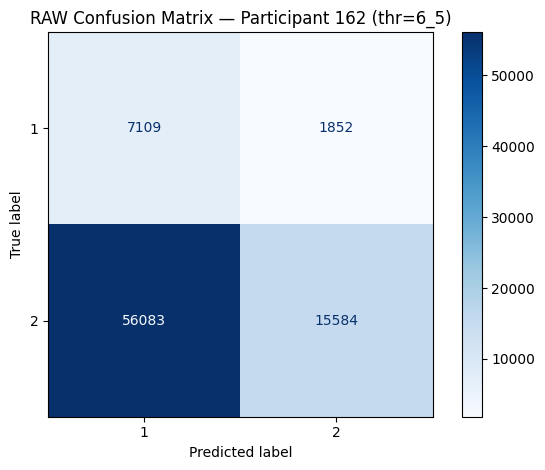

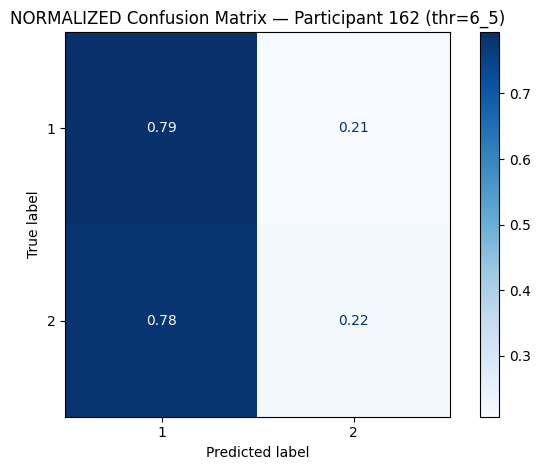

In [5]:
# ======================================================
# CONFUSION MATRIX — SINGLE PARTICIPANT (REFERENCE)
# ======================================================

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ------------------------------------------------------
# CONFIG — άλλαξέ τα όπως θες
# ------------------------------------------------------
ROOT_PATH = (
    "/run/user/1037/gvfs/smb-share:server=ait-pdfs.win.dtu.dk,share=department/Man/"
    "Public/4233-81647-eMOTIONAL-Cities/5 Data/ECDTU/E4/completed"
)

PARTICIPANT = "162"        # π.χ. "162"
THRESHOLD   = "6_5"        # όπως εμφανίζεται στο filename
NB_CLASSES  = 2            # Stress / Calm

# ------------------------------------------------------
# Load pickle
# ------------------------------------------------------
pkl_path = os.path.join(
    ROOT_PATH,
    PARTICIPANT,
    "Data",
    f"test_results_thr{THRESHOLD}.pkl"
)

print("Loading:", pkl_path)

with open(pkl_path, "rb") as f:
    data = pickle.load(f)

# ------------------------------------------------------
# Collect ALL EMA labels across folds
# ------------------------------------------------------
y_true_all = []
y_pred_all = []

for fr in data["fold_results"]:
    y_true_all.append(np.asarray(fr["labels_true_ema"]))
    y_pred_all.append(np.asarray(fr["labels_pred_ema"]))

y_true = np.concatenate(y_true_all)
y_pred = np.concatenate(y_pred_all)

labels = list(range(1, NB_CLASSES + 1))

# ------------------------------------------------------
# RAW confusion matrix
# ------------------------------------------------------
cm_raw = confusion_matrix(
    y_true,
    y_pred,
    labels=labels
)

disp_raw = ConfusionMatrixDisplay(
    confusion_matrix=cm_raw,
    display_labels=labels
)

disp_raw.plot(cmap="Blues", values_format="d")
plt.title(f"RAW Confusion Matrix — Participant {PARTICIPANT} (thr={THRESHOLD})")
plt.tight_layout()
plt.show()

# ------------------------------------------------------
# NORMALIZED confusion matrix (row-wise)
# ------------------------------------------------------
cm_norm = confusion_matrix(
    y_true,
    y_pred,
    labels=labels,
    normalize="true"
)

disp_norm = ConfusionMatrixDisplay(
    confusion_matrix=cm_norm,
    display_labels=labels
)

disp_norm.plot(cmap="Blues", values_format=".2f")
plt.title(f"NORMALIZED Confusion Matrix — Participant {PARTICIPANT} (thr={THRESHOLD})")
plt.tight_layout()
plt.show()


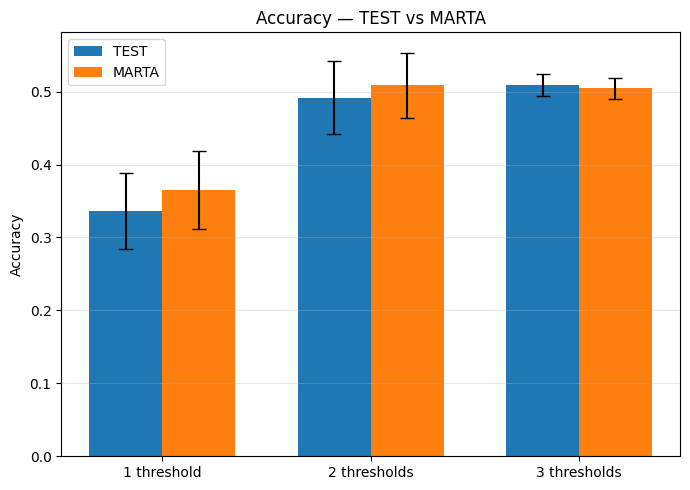

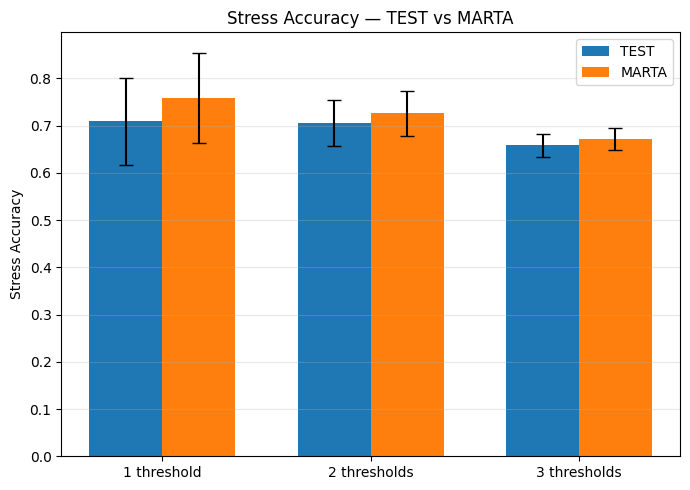

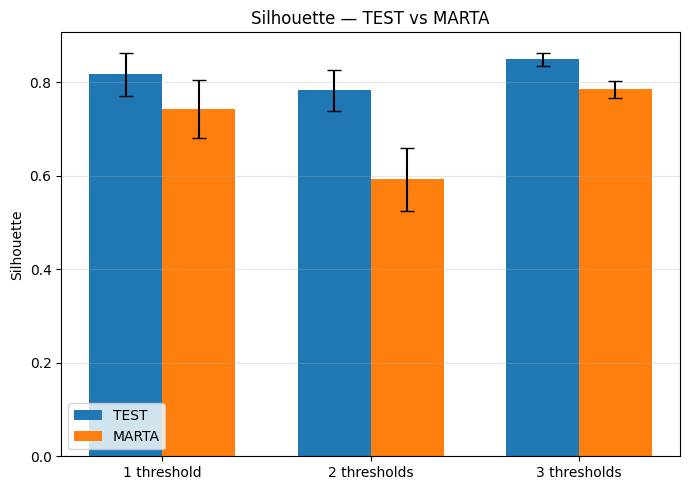

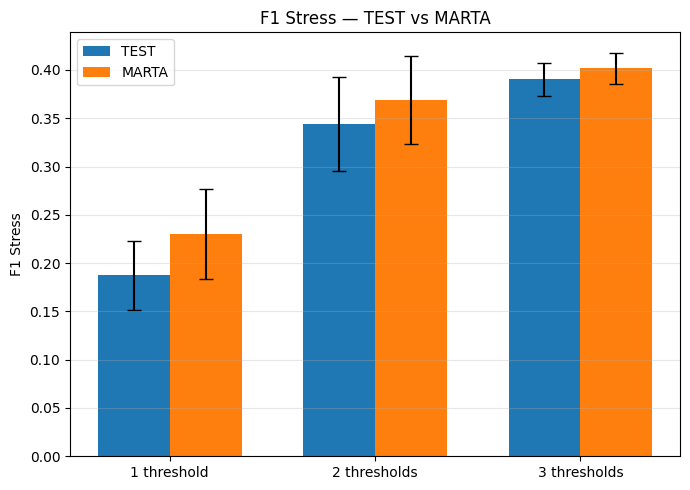

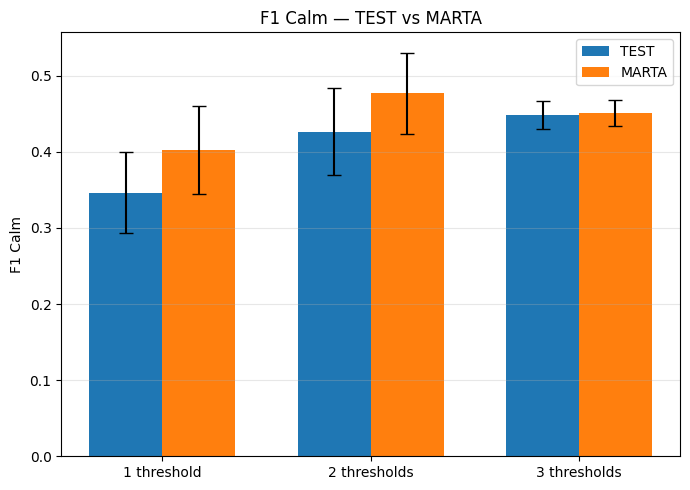

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------
# CONFIG
# ------------------------------------------------------
GROUPS = {
    "1 threshold": df_1thr,
    "2 thresholds": df_2thr,
    "3 thresholds": df_3thr,
}

METRICS = {
    "Accuracy": ("test_mean_acc", "marta_mean_acc"),
    "Stress Accuracy": ("test_mean_acc_stress", "marta_mean_acc_stress"),
    "Silhouette": ("test_mean_sil", "marta_mean_sil"),
    "F1 Stress": ("test_mean_f1_stress", "marta_mean_f1_stress"),
    "F1 Calm": ("test_mean_f1_calm", "marta_mean_f1_calm"),
}

COLORS = {
    "TEST": "#1f77b4",    # blue
    "MARTA": "#ff7f0e",   # orange
}


# ------------------------------------------------------
# Helper: mean + SEM
# ------------------------------------------------------
def mean_sem(x):
    x = x.dropna()
    mean = x.mean()
    sem = x.std(ddof=1) / np.sqrt(len(x)) if len(x) > 1 else 0.0
    return mean, sem


# ------------------------------------------------------
# MAIN PLOTTING LOOP
# ------------------------------------------------------
for metric_name, (test_col, marta_col) in METRICS.items():

    labels = []
    test_means, test_sems = [], []
    marta_means, marta_sems = [], []

    for group_name, df in GROUPS.items():
        labels.append(group_name)

        m_test, se_test = mean_sem(df[test_col])
        m_marta, se_marta = mean_sem(df[marta_col])

        test_means.append(m_test)
        test_sems.append(se_test)
        marta_means.append(m_marta)
        marta_sems.append(se_marta)

    # --------------------------------------------------
    # Plot
    # --------------------------------------------------
    x = np.arange(len(labels))
    width = 0.35

    plt.figure(figsize=(7, 5))

    plt.bar(
        x - width / 2,
        test_means,
        width,
        yerr=test_sems,
        capsize=5,
        label="TEST",
        color=COLORS["TEST"]
    )

    plt.bar(
        x + width / 2,
        marta_means,
        width,
        yerr=marta_sems,
        capsize=5,
        label="MARTA",
        color=COLORS["MARTA"]
    )

    plt.xticks(x, labels)
    plt.ylabel(metric_name)
    plt.title(f"{metric_name} — TEST vs MARTA")
    plt.legend()
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()
